# Cyber Bullying Prediction

## Download Dataset

In [1]:
# Install or upgrade the Kaggle Python package quietly.
!pip install -U -q kaggle

# Create a directory named .kaggle in the user's home directory.
!mkdir -p ~/.kaggle

# Create an empty file named kaggle.json within the .kaggle directory.
!touch ~/.kaggle/kaggle.json

# Write a JSON-formatted Kaggle API key to kaggle.json.
!echo "{\"username\":\"tameemikramullah\",\"key\":\"0b073b5f2706af7a6582562b33d56a99\"}" > ~/.kaggle/kaggle.json

# Set appropriate permissions to protect the API key.
!chmod 600 ~/.kaggle/kaggle.json


In [2]:
# Download a Kaggle dataset named "cyberbullying-classification" and save it to the "data/" directory.
# The "-d" flag specifies the dataset name, and the "-p" flag specifies the target download directory.
!kaggle datasets download -d andrewmvd/cyberbullying-classification -p data/


 71%|██████████████████████████▉           | 2.00M/2.82M [00:00<00:00, 2.87MB/s]
100%|██████████████████████████████████████| 2.82M/2.82M [00:00<00:00, 3.30MB/s]


In [3]:
# List the contents of the "data" directory to view the files and directories.
!ls data

# Unzip the "cyberbullying-classification.zip" file located in the "data" directory and extract its contents into the same directory.
# The "-d" flag specifies the target directory for extraction.
!sudo unzip data/cyberbullying-classification.zip -d data/

# Remove the "cyberbullying-classification.zip" file from the "data" directory.
!sudo rm data/cyberbullying-classification.zip


cyberbullying-classification.zip
Archive:  data/cyberbullying-classification.zip
  inflating: data/cyberbullying_tweets.csv  


## Import the necessary libraries

In [4]:
# Import necessary libraries
import pandas as pd              # Data manipulation with pandas
import numpy as np               # Numerical operations with numpy
import re                        # Regular expressions for text processing
import seaborn as sns            # Data visualization with seaborn
from wordcloud import WordCloud  # Word cloud visualization
import matplotlib.pyplot as plt  # Plotting with matplotlib
from nltk.stem import WordNetLemmatizer  # Lemmatization from NLTK
from sklearn.svm import LinearSVC         # Support Vector Machine classifier from scikit-learn
from sklearn.model_selection import train_test_split  # Splitting dataset for training and testing
from sklearn.feature_extraction.text import TfidfVectorizer  # TF-IDF vectorization
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score  # Evaluation metrics
from sklearn.naive_bayes import MultinomialNB  # Multinomial Naive Bayes classifier

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Download Open Multilingual WordNet (OMW) data
import nltk
nltk.download('omw-1.4')


[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

## Import the data

In [5]:
# Read a CSV file named 'cyberbullying_tweets.csv' into a pandas DataFrame.
dataframe = pd.read_csv('data/cyberbullying_tweets.csv')

# Display the first 5 rows of the DataFrame to inspect the data.
dataframe.head(n=5)


,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


## Exploratory Data Analysis (EDA)

## Data validation

In [6]:
# Extract and display the unique values in the 'cyberbullying_type' column of the DataFrame.
dataframe['cyberbullying_type'].unique()


array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

In [7]:
# Randomly sample and display 5 rows from the DataFrame to get a glimpse of the data.
dataframe.sample(5)


,tweet_text,cyberbullying_type
35535,"Kinda is it not , I been to doctors cause they...",age
9734,RT @Addiecfc: Grow myself some tits or put on ...,gender
17830,"Dear SC No pollution, only 'peaceful' #Jihad s...",religion
25630,@kencf0618 awesome! :D,other_cyberbullying
19549,The main point is they can't all be terrorists...,religion


In [8]:
# Check for missing (null) values in each column of the DataFrame and calculate the sum of missing values.
dataframe.isnull().sum()


tweet_text            0
cyberbullying_type    0
dtype: int64

In [9]:
# Calculate the total count of duplicated rows in the DataFrame.
dataframe.duplicated().sum()


36

In [10]:
# Remove duplicate rows based on the 'tweet_text' column, keeping the first occurrence of each unique text.
dataframe.drop_duplicates(subset='tweet_text', keep='first', inplace=True)


### Visualise label count

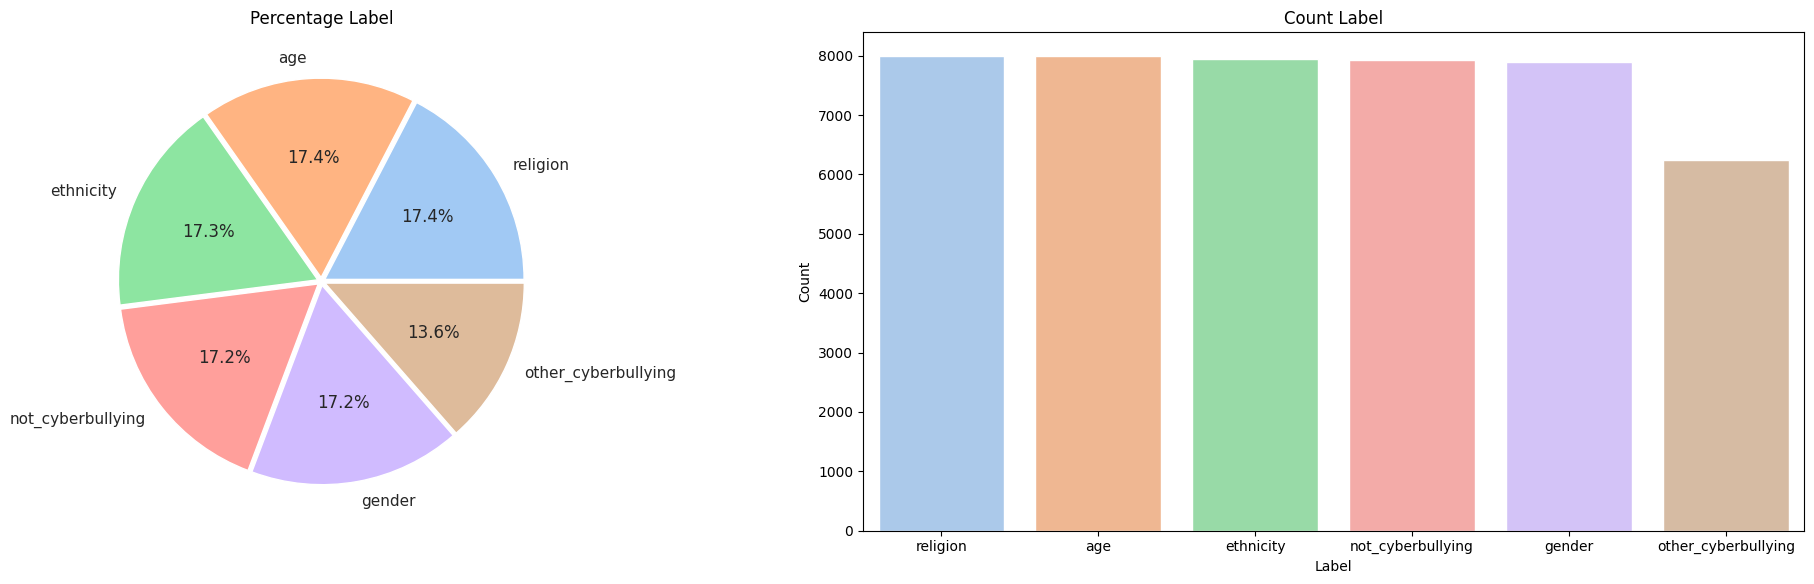

In [11]:
# Calculate the count of each unique value in the 'cyberbullying_type' column.
lc = dataframe['cyberbullying_type'].value_counts()

# Create a subplot with one row and two columns, specifying the figure size.
f, a = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Set the plotting style and color palette.
sns.set_theme(style='darkgrid', palette='pastel')
color = sns.color_palette(palette='pastel')

# Define an explode list for pie chart to emphasize slices.
explode = [0.02] * len(lc)

# Create a pie chart on the left subplot ('a[0]') showing the percentage distribution of labels.
a[0].pie(lc.values, labels=lc.index, autopct='%1.1f%%', colors=color, explode=explode)
a[0].set_title('Percentage Label')

# Create a bar plot on the right subplot ('a[1]') showing the count of each label.
sns.barplot(x=lc.index, y=lc.values, ax=a[1])
a[1].set_title('Count Label')
a[1].set_xlabel('Label')
a[1].set_ylabel('Count')

# Show the plot with tight layout.
plt.tight_layout()
plt.show()


### Distribution analysis

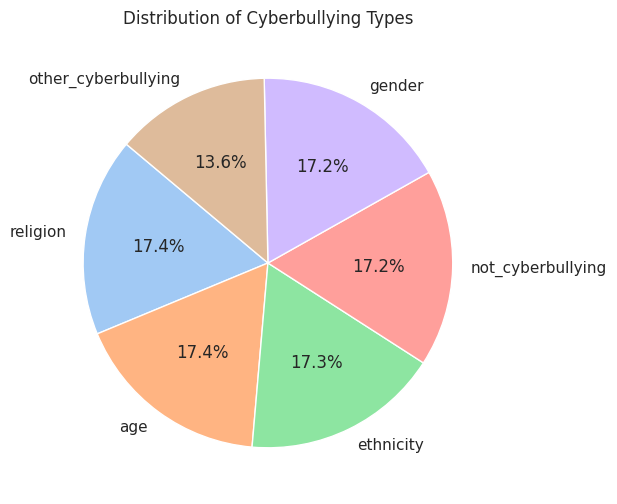

In [12]:
# Calculate the count of each cyberbullying type
cyberbullying_counts = dataframe['cyberbullying_type'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 6))
plt.pie(cyberbullying_counts, labels=cyberbullying_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))

# Add a title
plt.title('Distribution of Cyberbullying Types')

# Display the pie chart
plt.show()

### Identification of dirty words

In [13]:
# Retrieve and display the text of the tweet located at index 100 in the 'tweet_text' column.
dataframe['tweet_text'].iloc[100]


"@mirebotan84 @RamiAlLolah I support that. I don't like people like Rami who complain about the things he supports when done to others."

### Clean the tweets

In [14]:
# Install the 'tweet-preprocessor' library using pip.
!pip install tweet-preprocessor


In [15]:
# Import the 'preprocessor' library as 'p' for tweet text preprocessing.
import preprocessor as p

# Define a function 'preprocess_tweet' that takes a DataFrame row and cleans the tweet text.
def preprocess_tweet(row):
    # Extract the tweet text from the row.
    t = row['tweet_text']
    
    # Use the 'clean' method from 'preprocessor' to preprocess and clean the tweet text.
    t = p.clean(t)
    
    # Return the cleaned tweet text.
    return t


In [16]:
# Apply the 'preprocess_tweet' function to each row in the DataFrame's 'tweet_text' column.
dataframe['tweet_text'] = dataframe.apply(preprocess_tweet, axis=1)


In [17]:
# Display the first few rows of the DataFrame to inspect the tweet text preprocessing.
dataframe.head()


,tweet_text,cyberbullying_type
0,"In other words , your food was crapilicious!",not_cyberbullying
1,Why is so white?,not_cyberbullying
2,a classy whore? Or more red velvet cupcakes?,not_cyberbullying
3,"meh. thanks for the heads up, but not too conc...",not_cyberbullying
4,This is an ISIS account pretending to be a Kur...,not_cyberbullying


## Further cleaning

In [18]:
# Import necessary libraries for text cleaning.
import re
import string

# Define a function 'cleaning_data' for text cleaning and preprocessing.
def cleaning_data(data):
    # Convert text to lowercase.
    data = data.lower()
    
    # Remove mentions (e.g., @username).
    data = re.sub(r'@\S+', "", data)
    
    # Remove URLs (e.g., http://example.com).
    data = re.sub(r'http\S+', '', data)
    
    # Remove pic.twitter.com links.
    data = re.sub(r'pic.\S+', '', data)
    
    # Remove digits and numbers.
    data = re.sub(r'\d+', "", data)
    
    # Remove non-alphabet characters (excluding apostrophes).
    data = re.sub(r"[^a-zA-Z']", ' ', data)
    
    # Remove single characters (e.g., 'a' or 'A') surrounded by spaces.
    data = re.sub(r"\s+[a-zA-Z]\s+", " ", data + " ")
    
    # Remove punctuation characters.
    data = ''.join([i for i in data if i not in string.punctuation])
    
    # Return the cleaned and preprocessed text.
    return data

# Apply the 'cleaning_data' function to the 'tweet_text' column and store the result in 'new_text' column.
dataframe['new_text'] = dataframe['tweet_text'].apply(cleaning_data)

# Display the cleaned and preprocessed text at index 100 in the 'new_text' column.
dataframe['new_text'].iloc[100]


'i support that dont like people like rami who complain about the things he supports when done to others  '

In [19]:
# Display the first few rows of the DataFrame to inspect the text cleaning and preprocessing.
dataframe.head()


,tweet_text,cyberbullying_type,new_text
0,"In other words , your food was crapilicious!",not_cyberbullying,in other words your food was crapilicious
1,Why is so white?,not_cyberbullying,why is so white
2,a classy whore? Or more red velvet cupcakes?,not_cyberbullying,a classy whore or more red velvet cupcakes
3,"meh. thanks for the heads up, but not too conc...",not_cyberbullying,meh thanks for the heads up but not too conc...
4,This is an ISIS account pretending to be a Kur...,not_cyberbullying,this is an isis account pretending to be kurdi...


### Remove stop words

In [20]:
# Import the 'remove_stopwords' function from the gensim library for stopword removal.
from gensim.parsing.preprocessing import remove_stopwords

# Define a function 'stopword_removal' for removing stopwords from tweet text.
def stopword_removal(row):
    # Extract the tweet text from the row.
    t = row['tweet_text']
    
    # Use the 'remove_stopwords' function to remove stopwords from the text.
    t = remove_stopwords(t)
    
    # Return the text with stopwords removed.
    return t

# Apply the 'stopword_removal' function to the 'tweet_text' column and update the column with stopwords removed.
dataframe['tweet_text'] = dataframe.apply(stopword_removal, axis=1)

# Display the first few rows of the DataFrame to inspect the text after stopword removal.
dataframe.head()


,tweet_text,cyberbullying_type,new_text
0,"In words , food crapilicious!",not_cyberbullying,in other words your food was crapilicious
1,Why white?,not_cyberbullying,why is so white
2,classy whore? Or red velvet cupcakes?,not_cyberbullying,a classy whore or more red velvet cupcakes
3,"meh. thanks heads up, concerned angry dude twi...",not_cyberbullying,meh thanks for the heads up but not too conc...
4,This ISIS account pretending Kurdish account. ...,not_cyberbullying,this is an isis account pretending to be kurdi...


### Remove punctuation

In [21]:
# Convert the 'tweet_text' column to lowercase and remove non-alphanumeric characters and extra spaces.
dataframe['tweet_text'] = dataframe['tweet_text'].str.lower().str.replace('[^\w\s]', ' ').str.replace('\s\s+', ' ')

# Display the first few rows of the DataFrame to inspect the cleaned text.
dataframe.head()


,tweet_text,cyberbullying_type,new_text
0,"in words , food crapilicious!",not_cyberbullying,in other words your food was crapilicious
1,why white?,not_cyberbullying,why is so white
2,classy whore? or red velvet cupcakes?,not_cyberbullying,a classy whore or more red velvet cupcakes
3,"meh. thanks heads up, concerned angry dude twi...",not_cyberbullying,meh thanks for the heads up but not too conc...
4,this isis account pretending kurdish account. ...,not_cyberbullying,this is an isis account pretending to be kurdi...


### Tokenization

In [22]:
from nltk.tokenize import word_tokenize
def length(text):
    return len(word_tokenize(text))
dataframe['word_count'] = dataframe['tweet_text'].apply(length)

In [23]:
dataframe.head()

,tweet_text,cyberbullying_type,new_text,word_count
0,"in words , food crapilicious!",not_cyberbullying,in other words your food was crapilicious,6
1,why white?,not_cyberbullying,why is so white,3
2,classy whore? or red velvet cupcakes?,not_cyberbullying,a classy whore or more red velvet cupcakes,8
3,"meh. thanks heads up, concerned angry dude twi...",not_cyberbullying,meh thanks for the heads up but not too conc...,11
4,this isis account pretending kurdish account. ...,not_cyberbullying,this is an isis account pretending to be kurdi...,12


### Remove punctuations

In [24]:
# Define a function 'remove_punct' to remove punctuation from text.
def remove_punct(text):
    # Use the 'translate' method with 'str.maketrans' to remove punctuation characters.
    return text.translate(str.maketrans('', '', string.punctuation))

# Apply the 'remove_punct' function to the 'tweet_text' column to create a 'no_punctuation' column.
dataframe['no_punctuation'] = dataframe['tweet_text'].apply(remove_punct)

# Convert the 'no_punctuation' column to lowercase.
dataframe['no_punctuation'] = dataframe['no_punctuation'].apply(lambda x: x.lower())

# Display the 'no_punctuation' column with text having punctuation removed and converted to lowercase.
dataframe['no_punctuation']


0                              in words  food crapilicious
1                                                why white
2                      classy whore or red velvet cupcakes
3         meh thanks heads up concerned angry dude twitter
4        this isis account pretending kurdish account l...
                               ...                        
47687    black ppl arent expected anything depended any...
47688    turner withhold disappointment turner called c...
47689    i swear god this dumb nigger bitch i got bleac...
47690    yea fuck rt  if youre a nigger fucking unfollo...
47691    bro u gotta chill rt  dog fuck kp dumb nigger ...
Name: no_punctuation, Length: 46017, dtype: object

### Remove stop words

In [25]:
# Import the necessary libraries for text preprocessing.
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Define a function 'lower' to convert text to lowercase.
def lower(text):
    return text.lower()

# Apply the 'lower' function to convert the 'no_punctuation' column to lowercase.
dataframe['no_punctuation'] = dataframe['no_punctuation'].apply(lower)

# Define a function 'remove_stopwords' to remove stopwords from text.
def remove_stopwords(text):
    # Get the set of English stopwords.
    stop_words = set(stopwords.words('english'))
    
    # Initialize a list for storing non-stopwords.
    new_text = []
    
    # Tokenize the text and filter out stopwords.
    for el in word_tokenize(text):
        if not el in stop_words:
            new_text.append(el)
    
    # Return the text with stopwords removed.
    return new_text

# Apply the 'remove_stopwords' function to the 'no_punctuation' column to create a 'no_stopwords' column.
dataframe['no_stopwords'] = dataframe['no_punctuation'].apply(remove_stopwords)


In [26]:
# Display the first few rows of the DataFrame to inspect the text after removing punctuation and stopwords.
dataframe.head()


,tweet_text,cyberbullying_type,new_text,word_count,no_punctuation,no_stopwords
0,"in words , food crapilicious!",not_cyberbullying,in other words your food was crapilicious,6,in words food crapilicious,"[words, food, crapilicious]"
1,why white?,not_cyberbullying,why is so white,3,why white,[white]
2,classy whore? or red velvet cupcakes?,not_cyberbullying,a classy whore or more red velvet cupcakes,8,classy whore or red velvet cupcakes,"[classy, whore, red, velvet, cupcakes]"
3,"meh. thanks heads up, concerned angry dude twi...",not_cyberbullying,meh thanks for the heads up but not too conc...,11,meh thanks heads up concerned angry dude twitter,"[meh, thanks, heads, concerned, angry, dude, t..."
4,this isis account pretending kurdish account. ...,not_cyberbullying,this is an isis account pretending to be kurdi...,12,this isis account pretending kurdish account l...,"[isis, account, pretending, kurdish, account, ..."


### Lematisation

In [27]:
# Import the nltk library and download the WordNet dataset.
import nltk
nltk.download("omw-1.4")

# Download the WordNet dataset using the nltk downloader.
!python3 -m nltk.downloader wordnet

# Unzip the downloaded WordNet dataset to the nltk corpora directory.
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/


[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/opt/conda/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/w

In [28]:
# Define a function 'lemmatize' to lemmatize words in a list.
def lemmatize(words):
    # Initialize a list to store lemmatized words.
    new_words = []
    
    # Create a WordNetLemmatizer instance.
    lem = WordNetLemmatizer()
    
    # Iterate through the words and lemmatize each one.
    for w in words:
        new_words.append(lem.lemmatize(w))
    
    # Return the list of lemmatized words.
    return new_words

# Apply the 'lemmatize' function to the 'no_stopwords' column to create a 'lemmatized' column.
dataframe['lemmatized'] = dataframe['no_stopwords'].apply(lemmatize)


### Count Vectoriser

In [29]:
# Import the Counter class from the collections library.
from collections import Counter

# Initialize a Counter to keep track of the vocabulary.
vocab = Counter()

# Define a function 'add_to_vocab' to update the vocabulary with words.
def add_to_vocab(words):
    # Access the global 'vocab' Counter and update it with the words.
    global vocab
    vocab.update(words)

# Apply the 'add_to_vocab' function to the 'lemmatized' column to build the vocabulary.
dataframe.lemmatized.apply(add_to_vocab)

# Calculate the size of the vocabulary.
vocab_size = len(vocab)

# Print the vocabulary size.
print("Vocabulary size:", vocab_size)


Vocabulary size: 40826


In [30]:
# Retrieve and display the 50 most common words in the vocabulary.
most_common_words = vocab.most_common(50)
most_common_words


[('school', 9137),
 ('fuck', 6061),
 ('like', 5897),
 ('nigger', 5577),
 ('girl', 5523),
 ('joke', 5483),
 ('dumb', 5327),
 ('bully', 5282),
 ('high', 5097),
 ('people', 4822),
 ('muslim', 4727),
 ('bullied', 4664),
 ('u', 4649),
 ('im', 4335),
 ('gay', 4321),
 ('dont', 4319),
 ('rape', 4238),
 ('idiot', 3441),
 ('woman', 3155),
 ('black', 2848),
 ('as', 2794),
 ('amp', 2567),
 ('bitch', 2509),
 ('know', 2456),
 ('white', 2298),
 ('think', 2268),
 ('right', 2200),
 ('christian', 2126),
 ('got', 1827),
 ('time', 1749),
 ('fucking', 1670),
 ('want', 1605),
 ('youre', 1535),
 ('shit', 1509),
 ('ur', 1509),
 ('called', 1492),
 ('thing', 1469),
 ('terrorist', 1395),
 ('year', 1390),
 ('thats', 1388),
 ('hate', 1387),
 ('support', 1321),
 ('need', 1294),
 ('said', 1286),
 ('look', 1267),
 ('islamic', 1267),
 ('obama', 1232),
 ('female', 1209),
 ('friend', 1202),
 ('good', 1201)]

### Remove rare

In [31]:
# Create a list of words that occur at least 3 times in the vocabulary.
words = [key for key, val in vocab.items() if val >= 3]

# Calculate the size of the reduced vocabulary.
vocab_size = len(words)

# Print the size of the reduced vocabulary.
print(vocab_size)

# Define a function 'remove_rare' to remove words not in the reduced vocabulary.
def remove_rare(text):
    # Access the global 'words' list and remove words not in the list from the text.
    global words
    return [el for el in text if el in words]

# Apply the 'remove_rare' function to the 'lemmatized' column to filter out rare words.
dataframe.lemmatized = dataframe.lemmatized.apply(remove_rare)


12385


CountVectorizer creates a vocabulary by gathering all distinct tokens from the tokenized text. Each token in the lexicon has its own specific index.

### Train test split

In [32]:
# Split the DataFrame into training and testing sets for text and corresponding labels.
X_train, X_test, y_train, y_test = train_test_split(dataframe[['lemmatized']], dataframe['cyberbullying_type'])


In [33]:

print("Shape of x_train:", X_train.shape)
print("Shape of x_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of x_train: (34512, 1)
Shape of x_test: (11505, 1)
Shape of y_train: (34512,)
Shape of y_test: (11505,)


In [34]:
# Initialize a new Counter to keep track of the vocabulary.
vocab = Counter()

# Define a function 'add_to_vocab' to update the vocabulary with words.
def add_to_vocab(words):
    # Access the global 'vocab' Counter and update it with the words.
    global vocab
    vocab.update(words)

# Apply the 'add_to_vocab' function to the 'lemmatized' column of the training data (X_train).
X_train.lemmatized.apply(add_to_vocab)

# Apply the 'add_to_vocab' function to the 'lemmatized' column of the entire DataFrame (dataframe).
dataframe.lemmatized.apply(add_to_vocab)

# Calculate the size of the updated vocabulary.
vocab_size = len(vocab)

# Print the vocabulary size.
vocab_size


12385

### Tokeniser

In [35]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Initialize a Tokenizer for text-to-sequence conversion.
tokenizer = Tokenizer()

# Fit the tokenizer on the lemmatized text data from the training set (X_train).
tokenizer.fit_on_texts(X_train.lemmatized)

# Convert the lemmatized text data from both the training and testing sets to sequences.
X_train = tokenizer.texts_to_sequences(X_train.lemmatized)
X_test = tokenizer.texts_to_sequences(X_test.lemmatized)


In [36]:
# Find the maximum length of sequences in the 'lemmatized' column of the DataFrame.
max_size = len(max(dataframe.lemmatized, key=lambda x: len(x)))

# Print the maximum sequence length.
max_size


304

In [37]:
# Import the necessary libraries for data preprocessing.
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OrdinalEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pad the sequences in the training and testing sets to a maximum length.
X_train = pad_sequences(X_train, maxlen=max_size, padding='post')
X_test = pad_sequences(X_test, maxlen=max_size, padding='post')

# Initialize an OrdinalEncoder for encoding labels.
enc = OrdinalEncoder()

# Encode the labels in both the training and testing sets using one-hot encoding.
y_train = to_categorical(enc.fit_transform(X=y_train.to_frame()), num_classes=6)
y_test = to_categorical(enc.fit_transform(X=y_test.to_frame()), num_classes=6)


## Classification

### Neural Network

In [38]:
# Import the necessary libraries.
from keras import backend as K

# Define a custom recall metric for Keras.
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# Define a custom precision metric for Keras.
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# Define a custom F1 score metric for Keras using the precision and recall metrics.
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


In [39]:
# Import the necessary Keras libraries.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras import regularizers

# Define a function to generate a neural network model.
def generate_model(vocab_size, max_length):
    # Initialize a Sequential model.
    model = Sequential()
    
    # Add an Embedding layer with input length and embedding dimension.
    model.add(Embedding(vocab_size, 100, input_length=max_length))
    
    # Add a 1D Convolutional layer with filters and kernel size.
    model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
    
    # Add a MaxPooling layer with a specified pool size.
    model.add(MaxPooling1D(pool_size=2))
    
    # Flatten the output from the previous layers.
    model.add(Flatten())
    
    # Add a Dense layer with 10 units and ReLU activation, along with L1L2 regularization.
    model.add(Dense(10, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)))
    
    # Add the final Dense layer with 6 units (for 6 classes) and softmax activation.
    model.add(Dense(6, activation='softmax'))
    
    # Compile the model with categorical cross-entropy loss and the Adam optimizer.
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model


#### Create model

In [40]:
# Generate a neural network model with the specified vocabulary size and maximum sequence length.
model = generate_model(vocab_size, max_size)

# Train the model on the training data and labels for 20 epochs with verbose logging.
history = model.fit(X_train, y_train, epochs=20, verbose=2)


Epoch 1/20
1079/1079 - 57s - loss: 0.8183 - accuracy: 0.6445 - 57s/epoch - 52ms/step
Epoch 2/20
1079/1079 - 56s - loss: 0.4130 - accuracy: 0.8298 - 56s/epoch - 52ms/step
Epoch 3/20
1079/1079 - 56s - loss: 0.3036 - accuracy: 0.8846 - 56s/epoch - 52ms/step
Epoch 4/20
1079/1079 - 55s - loss: 0.2250 - accuracy: 0.9171 - 55s/epoch - 51ms/step
Epoch 5/20
1079/1079 - 56s - loss: 0.1655 - accuracy: 0.9412 - 56s/epoch - 52ms/step
Epoch 6/20
1079/1079 - 55s - loss: 0.1214 - accuracy: 0.9572 - 55s/epoch - 51ms/step
Epoch 7/20
1079/1079 - 55s - loss: 0.0965 - accuracy: 0.9671 - 55s/epoch - 51ms/step
Epoch 8/20
1079/1079 - 55s - loss: 0.0796 - accuracy: 0.9722 - 55s/epoch - 51ms/step
Epoch 9/20
1079/1079 - 57s - loss: 0.0686 - accuracy: 0.9755 - 57s/epoch - 53ms/step
Epoch 10/20
1079/1079 - 57s - loss: 0.0613 - accuracy: 0.9780 - 57s/epoch - 53ms/step
Epoch 11/20
1079/1079 - 56s - loss: 0.0558 - accuracy: 0.9807 - 56s/epoch - 52ms/step
Epoch 12/20
1079/1079 - 55s - loss: 0.0515 - accuracy: 0.9812 -

#### Evaluate

In [41]:

# Print the maximum training accuracy achieved during training.
print('train_accuracy : ', max(history.history['accuracy']) * 100)


train_accuracy :  98.50776791572571


In [42]:
# Evaluate the model on the test data to calculate loss and accuracy.
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

In [43]:
# Import necessary libraries for performance evaluation.
import numpy as np
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Make predictions with the trained model on the test data.
y_pred = model.predict(X_test, batch_size=128, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Convert one-hot encoded labels to numpy arrays.
y_test_np = np.argmax(y_test, axis=1)

# Calculate precision, recall, and F1 score for the classification.
precision = precision_score(y_test_np, y_pred_classes, average='weighted')
recall = recall_score(y_test_np, y_pred_classes, average='weighted')
f1 = f1_score(y_test_np, y_pred_classes, average='weighted')

# Print the calculated precision, recall, and F1 score.
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Create a dictionary to store evaluation metrics.
e = {
    'Model': "Keras NN",
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}

# Generate a classification report for detailed metrics.
report = classification_report(y_test_np, y_pred_classes)

# Print the classification report.
print(report)


Precision: 0.79
Recall: 0.79
F1 Score: 0.79
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1977
           1       0.93      0.95      0.94      1987
           2       0.82      0.80      0.81      1979
           3       0.57      0.53      0.55      1993
           4       0.51      0.56      0.53      1545
           5       0.92      0.92      0.92      2024

    accuracy                           0.79     11505
   macro avg       0.78      0.78      0.78     11505
weighted avg       0.79      0.79      0.79     11505



## Prepare data for Logistic regression

In [44]:
# Import the necessary library for text vectorization.
from sklearn.feature_extraction.text import CountVectorizer

# Initialize a CountVectorizer.
countvectoriser = CountVectorizer()

# Fit and transform the 'new_text' column of the DataFrame to create a matrix of word counts.
matrix = countvectoriser.fit_transform(dataframe['new_text'])

# Convert the word count matrix to a DataFrame with feature names as columns.
word_matrix = pd.DataFrame(matrix.toarray(), columns=countvectoriser.get_feature_names_out())

# Extract a portion of the word count matrix (e.g., rows 100 to 104 and columns 190 to 199).
outputs = matrix.toarray()
portion_of_matrix = outputs[100:105, 190:200]


In [45]:
countvectoriser.get_feature_names_out()[:10]

array(['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaa',
       'aaaaaaaaaaaaaaaaaaaaaah', 'aaaaaaaaaah',
       'aaaaaaaaaajajajajajajajahahahajahaja', 'aaaaaaaahhhhhhh',
       'aaaaah'], dtype=object)

### Logistic Regression

In [46]:
# Extract the text data from the 'tweet_text' column.
x = dataframe['tweet_text']

# Factorize the labels in the 'cyberbullying_type' column to convert them into numeric values.
# The factorized labels are stored in 'y', and the unique labels in '_' are ignored.
y, _ = pd.factorize(dataframe['cyberbullying_type'], sort=True)

# Split the data into training and testing sets with a 75% training and 25% testing split ratio.
# The random_state is set for reproducibility.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)


In [47]:
# Import the necessary libraries for creating a pipeline and the Logistic Regression classifier.
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Create a pipeline with two steps:
# 1. TF-IDF vectorization using TfidfVectorizer.
# 2. Classification using Logistic Regression with the default regularization parameter C=1.0.
first_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer()),  # TF-IDF vectorization step
    ('classifier', LogisticRegression(C=1.0))  # Logistic Regression classifier step
])

# Fit the pipeline on the training data (x_train) and labels (y_train).
first_pipe.fit(x_train, y_train)


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', LogisticRegression())])

In [48]:
# Get the unique class names from the 'cyberbullying_type' column of the DataFrame.
class_names = dataframe['cyberbullying_type'].unique()
class_names


array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

In [49]:
# Make predictions on the test data using the trained pipeline.
y_pred = first_pipe.predict(x_test)

# Calculate and print the accuracy of the predictions.
print('Accuracy:{:.3f}'.format(accuracy_score(y_test, y_pred)))

# Generate a classification report for detailed metrics, specifying class names.
print(classification_report(y_test, y_pred, target_names=class_names))


Accuracy:0.828
                     precision    recall  f1-score   support

  not_cyberbullying       0.95      0.97      0.96      2004
             gender       0.97      0.97      0.97      1976
           religion       0.92      0.81      0.86      1974
other_cyberbullying       0.60      0.67      0.63      2049
                age       0.56      0.55      0.56      1530
          ethnicity       0.95      0.94      0.94      1972

           accuracy                           0.83     11505
          macro avg       0.82      0.82      0.82     11505
       weighted avg       0.83      0.83      0.83     11505



## Naive bayes

In [50]:
# Import the necessary libraries for creating a pipeline and the Multinomial Naive Bayes classifier.
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

# Create a pipeline with two steps:
# 1. TF-IDF vectorization using TfidfVectorizer.
# 2. Classification using Multinomial Naive Bayes.
nb_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer()),  # TF-IDF vectorization step
    ('classifier', MultinomialNB())  # Multinomial Naive Bayes classifier step
])

# Train the Naive Bayes model on the training data (x_train) and labels (y_train).
nb_pipe.fit(x_train, y_train)


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', MultinomialNB())])

In [51]:
# Predict labels on the test data using the trained Naive Bayes pipeline.
y_nb_pred = nb_pipe.predict(x_test)

# Print evaluation metrics for the Naive Bayes model.
print('Naive Bayes Model:')
# Calculate and print the accuracy of the predictions.
print('Accuracy: {:.3f}'.format(accuracy_score(y_test, y_nb_pred)))

# Generate a classification report for detailed metrics, specifying class names.
print(classification_report(y_test, y_nb_pred, target_names=class_names))


Naive Bayes Model:
Accuracy: 0.732
                     precision    recall  f1-score   support

  not_cyberbullying       0.69      0.98      0.81      2004
             gender       0.80      0.91      0.85      1976
           religion       0.79      0.83      0.81      1974
other_cyberbullying       0.71      0.40      0.51      2049
                age       0.63      0.19      0.29      1530
          ethnicity       0.70      0.97      0.82      1972

           accuracy                           0.73     11505
          macro avg       0.72      0.71      0.68     11505
       weighted avg       0.72      0.73      0.70     11505



## Support vector machines

In [52]:
# Import the necessary libraries for creating a pipeline and the SVM classifier.
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

# Create a pipeline with two steps:
# 1. TF-IDF vectorization using TfidfVectorizer.
# 2. Classification using Support Vector Machine (SVM).
svm_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer()),  # TF-IDF vectorization step
    ('classifier', SVC())  # Support Vector Machine (SVM) classifier step
])

# Train the SVM model on the training data (x_train) and labels (y_train).
svm_pipe.fit(x_train, y_train)


Pipeline(steps=[('vectorizer', TfidfVectorizer()), ('classifier', SVC())])

In [53]:
# Predict using the SVM model
y_svm_pred = svm_pipe.predict(x_test)

# Evaluate the SVM model
print('Support Vector Machine (SVM) Model:')
print('Accuracy: {:.3f}'.format(accuracy_score(y_test, y_svm_pred)))
print(classification_report(y_test, y_svm_pred, target_names=class_names))

Support Vector Machine (SVM) Model:
Accuracy: 0.831
                     precision    recall  f1-score   support

  not_cyberbullying       0.95      0.98      0.96      2004
             gender       0.97      0.97      0.97      1976
           religion       0.93      0.80      0.86      1974
other_cyberbullying       0.59      0.69      0.64      2049
                age       0.58      0.54      0.56      1530
          ethnicity       0.96      0.94      0.95      1972

           accuracy                           0.83     11505
          macro avg       0.83      0.82      0.82     11505
       weighted avg       0.84      0.83      0.83     11505



In [54]:
class_names

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

In [55]:
# Import the necessary library for performance evaluation.
from sklearn.metrics import precision_recall_fscore_support


c = None
# Get the unique class names from the 'cyberbullying_type' column of the DataFrame.
class_names = dataframe['cyberbullying_type'].unique()

# Define a function to evaluate a model's performance and gather metrics.
def evaluate_model(pipe, model_name):
    # Make predictions using the model.
    y_pred = pipe.predict(x_test)
    global c
    # Calculate accuracy, precision, recall, and F1-score.
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    c = svm_pipe
    # Return a dictionary with performance metrics.
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

# Initialize a list to store model performance results.
results = []
# Evaluate different models and append their performance metrics to the results list.
results.append(evaluate_model(first_pipe, 'Logistic Regression'))
results.append(evaluate_model(nb_pipe, 'Naive Bayes'))
results.append(evaluate_model(svm_pipe, 'SVM'))

# Append the performance metrics of a previously evaluated model (e) to the results.
results.append(e)

# Create a DataFrame to store and display the performance results.
results_df = pd.DataFrame(results)

# Display the DataFrame with model performance metrics.
results_df


,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.828075,0.833075,0.828075,0.829650
1,Naive Bayes,0.732290,0.723944,0.732290,0.695952
2,SVM,0.830508,0.838187,0.830508,0.832543
3,Keras NN,0.792960,0.793601,0.792960,0.792889


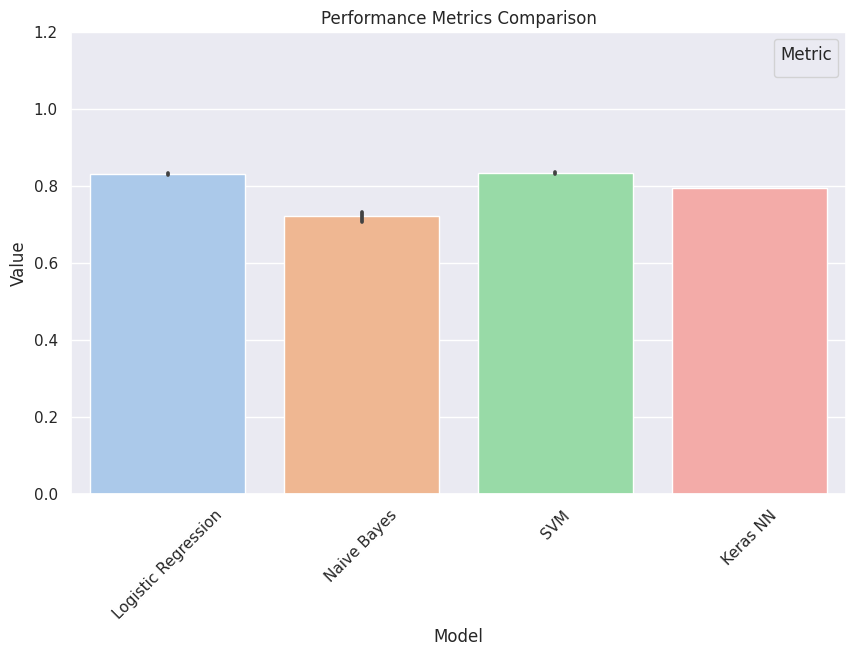

In [56]:
# Import necessary libraries for plotting.
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size for the plot.
plt.figure(figsize=(10, 6))

# Use seaborn to create a bar plot of performance metrics (Accuracy, Precision, Recall, F1-Score).
# The data is melted to facilitate plotting.
sns.barplot(
    x='Model',
    y='value',
    data=results_df.melt(id_vars=['Model'], value_vars=['Accuracy', 'Precision', 'Recall', 'F1-Score']),
    palette='pastel'  # Use a pastel color palette for the bars
)

# Set the title, labels, and limits for the plot.
plt.title('Performance Metrics Comparison')
plt.ylabel('Value')
plt.xlabel('Model')
plt.ylim(0, 1.2)  # Adjust the y-axis limit to better visualize the values
plt.legend(title='Metric')  # Add a legend with the metric title
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Display the plot.
plt.show()


In [57]:
text = None
def stopword_removal(row):
    t = row['txt']
    
    t = remove_stopwords(t)
    
    # Return the text with stopwords removed.
    return t

def remove_punc(row):
    t = row['txt']
    t = " ".join(t)
    t = t.replace('[^\w\s]', ' ').replace('\s\s+', ' ')
    t = lower(t)
    return t

def clean_text(txt):
    text = cleaning_data(txt)
    return text

def lemmatize(words):
    new_words = []
    lem = WordNetLemmatizer()
    for w in words:
        new_words.append(lem.lemmatize(w))
    return new_words

def to_df(arr):
    df = pd.DataFrame({'txt': arr})
    return df

def make_prediction(txt):
    print('original:',txt)

    global text
    text = clean_text(txt)
    text = [text]
    text = to_df(text)
    text['txt'] = text['txt'].apply(remove_stopwords)
    print('stop words removed:',text['txt'][0])

    text['txt'] = text['txt'].apply(lemmatize)
    print('lemmatized:', text['txt'][0])

    text['txt'] = text.apply(remove_punc, axis=1)
    print('punctuation words removed:',text['txt'][0])
    

    text = text['txt']
    prediction =  c.predict(text)
    if len(prediction) > 0:
        label = prediction[0]
        p = class_names[label]
        print("\n\n\n Predicted:", p)
    
    else:
        print("\n\n\n Predicted:", None)

In [58]:
make_prediction("a classy whore or more red velvet cupcakes")

original: a classy whore or more red velvet cupcakes
stop words removed: ['classy', 'whore', 'red', 'velvet', 'cupcakes']
lemmatized: ['classy', 'whore', 'red', 'velvet', 'cupcake']
punctuation words removed: classy whore red velvet cupcake



 Predicted: other_cyberbullying


In [59]:
make_prediction("no you re idiot since middle ages muslim takeo")

original: no you re idiot since middle ages muslim takeo
stop words removed: ['idiot', 'since', 'middle', 'ages', 'muslim', 'takeo']
lemmatized: ['idiot', 'since', 'middle', 'age', 'muslim', 'takeo']
punctuation words removed: idiot since middle age muslim takeo



 Predicted: ethnicity
